Here we build LSTM recurrent neural networks to predict the monthly sales of alcohol given previous sales.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Alcohol-Sales-Prediction

/content/drive/MyDrive/Alcohol-Sales-Prediction


In [ ]:
df=pd.read_csv("data.csv")
df.head()

,Date,Sales
0,1/1/1992,3459
1,1/2/1992,3458
2,1/3/1992,4002
3,1/4/1992,4564
4,1/5/1992,4221


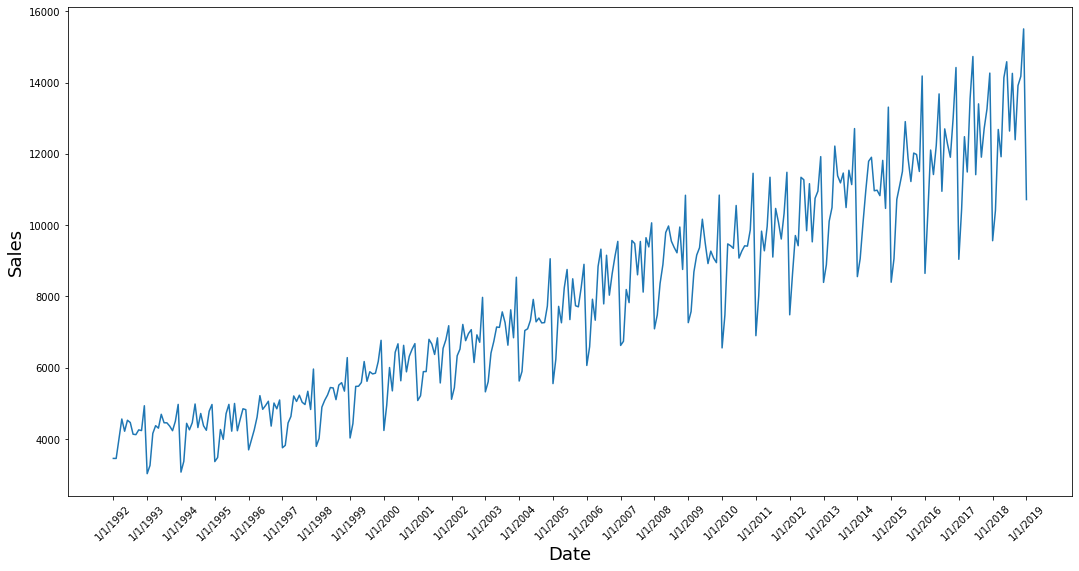

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(df['Date'], df['Sales'])
plt.xticks(np.arange(0,df.shape[0],12), rotation = 45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.show()

We use the first 264 rows (out of 325 rows) for training.

In [ ]:
num_train = 264
num_test = 61

First we normalize the data using the Min-Max scaler.

In [ ]:
training_set = df.iloc[:num_train, 1:2].values
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

There is clear seasonality in the monthly data, so we use the sliding window approach with window size 12.

In [ ]:
X_train = []
y_train = []
for i in range(12, num_train):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_train contains sales in rows 12 to 263 of the dataset, and each corresponding array in X_train contains the sales in the previous 12 months.

In [ ]:
X_train.shape

(252, 12, 1)

Build an LSTM model with 2 hidden layers.

In [ ]:
LSTM_model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], 1)),
        layers.LSTM(12, return_sequences=True),
        layers.LSTM(12),
        layers.Dense(1)
    ]
)

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 12)            672       
                                                                 
 lstm_1 (LSTM)               (None, 12)                1200      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
LSTM_model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
252/252 - 4s - loss: 0.0185 - 4s/epoch - 16ms/step
Epoch 2/100
252/252 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 3/100
252/252 - 1s - loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 4/100
252/252 - 1s - loss: 0.0090 - 1s/epoch - 5ms/step
Epoch 5/100
252/252 - 1s - loss: 0.0089 - 1s/epoch - 5ms/step
Epoch 6/100
252/252 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 7/100
252/252 - 1s - loss: 0.0087 - 1s/epoch - 5ms/step
Epoch 8/100
252/252 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 9/100
252/252 - 1s - loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 10/100
252/252 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 11/100
252/252 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 12/100
252/252 - 1s - loss: 0.0077 - 1s/epoch - 5ms/step
Epoch 13/100
252/252 - 1s - loss: 0.0081 - 1s/epoch - 5ms/step
Epoch 14/100
252/252 - 1s - loss: 0.0080 - 1s/epoch - 5ms/step
Epoch 15/100
252/252 - 1s - loss: 0.0075 - 1s/epoch - 5ms/step
Epoch 16/100
252/252 - 1s - loss: 0.0078 - 1s/epoch - 5ms/step


We evaluate our model on the alcohol sales for the last 61 rows.

In [ ]:
test_set = df.iloc[num_train - 12:, 1:2].values
test_set_scaled = scaler.transform(test_set)

test_set contains the last 73 rows of the dataset.

In [ ]:
X_test = []
for i in range(12, num_test+12):
    X_test.append(test_set_scaled[i-12:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(61, 12, 1)

Obtain and denormalize the predictions, then compute the MSE with respect to the test data.

In [ ]:
LSTM_predict_scaled = LSTM_model.predict(X_test)
LSTM_predict = scaler.inverse_transform(LSTM_predict_scaled)

In [ ]:
print(f"Mean Squared Error between descaled predictions and test values is {mean_squared_error(df.iloc[num_train:, 1:2].values, LSTM_predict)}.")

Mean Squared Error between descaled predictions and test values is 1096784.7368327125.


Plot the predicted sales with the actual sales for the test data.

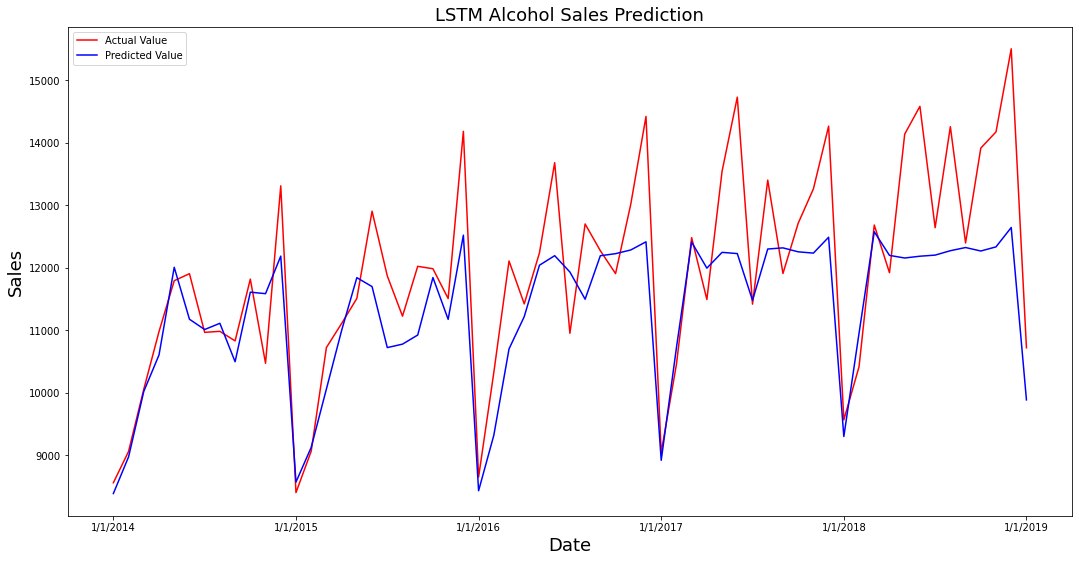

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(df.iloc[num_train:, 0], df.iloc[num_train:, 1:2].values, color = "red", label = "Actual Value")
plt.plot(df.iloc[num_train:, 0], LSTM_predict, color = "blue", label = "Predicted Value")
plt.xticks(np.arange(0,num_test,12))
plt.title('LSTM Alcohol Sales Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.legend()
plt.show()

We see that the the model tends to predict lower values than the actual prices. The model also performs worse for larger sales values, in particular the model becomes less sensitive to changes in input, which is shown by the flat regions near the end of the graph. This is due to the increasing nature of the sales data, and that the test data has exceeded the range of the values used in training. Because LSTM uses tanh and sigmoid activations, large inputs can easily cause neuron saturation which leads to relatively constant outputs.


Also note that the variance of the alcohol sales increases with the mean. We modify the LSTM model above by using a different normalization technique. For training, we divide each input array by it's first element then subtract it by 1 (elementwise). We do the same thing for the output observations, using the same values as the corresponding inputs for division.

In [ ]:
X_train_new = []
y_train_new = []
for i in range(12, num_train):
    X_train_new.append([x / training_set[i-12, 0] - 1 for x in training_set[i-11:i, 0]])
    y_train_new.append(training_set[i, 0] / training_set[i-12, 0] - 1)
X_train_new, y_train_new = np.array(X_train_new), np.array(y_train_new)
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))

We do not include the first element of each input in X_train_new as it is always normalized to 0.

In [ ]:
X_train_new.shape

(252, 11, 1)

Build another LSTM model with 2 hidden layers.

In [ ]:
LSTM_model_new = keras.Sequential(
    [
        keras.Input(shape=(X_train_new.shape[1], 1)),
        layers.LSTM(11, return_sequences=True),
        layers.LSTM(11),
        layers.Dense(1)
    ]
)

LSTM_model_new.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 11, 11)            572       
                                                                 
 lstm_5 (LSTM)               (None, 11)                1012      
                                                                 
 dense_2 (Dense)             (None, 1)                 12        
                                                                 
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_model_new.compile(loss = 'mean_squared_error', optimizer = 'adam')
LSTM_model_new.fit(X_train_new, y_train_new, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
252/252 - 5s - loss: 0.0030 - 5s/epoch - 20ms/step
Epoch 2/100
252/252 - 1s - loss: 0.0029 - 1s/epoch - 5ms/step
Epoch 3/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 4/100
252/252 - 2s - loss: 0.0029 - 2s/epoch - 7ms/step
Epoch 5/100
252/252 - 1s - loss: 0.0029 - 1s/epoch - 5ms/step
Epoch 6/100
252/252 - 1s - loss: 0.0029 - 1s/epoch - 5ms/step
Epoch 7/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 8/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 9/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 10/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 11/100
252/252 - 1s - loss: 0.0027 - 1s/epoch - 5ms/step
Epoch 12/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 13/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 14/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 15/100
252/252 - 1s - loss: 0.0027 - 1s/epoch - 5ms/step
Epoch 16/100
252/252 - 1s - loss: 0.0028 - 1s/epoch - 5ms/step


Again we evaluate our new model on the alcohol sales for the last 61 rows. X_test_new is computed in the same way as for the training inputs.

In [ ]:
X_test_new = []
for i in range(12, num_test+12):
    X_test_new.append([x / test_set[i-12, 0] - 1 for x in test_set[i-11:i, 0]])
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))

Obtain and descale the predictions using the first elements of the inputs, then compute the MSE with respect to the test data.

In [ ]:
LSTM_predict_new_scaled = LSTM_model_new.predict(X_test_new)
LSTM_predict_new = np.multiply(np.array(LSTM_predict_new_scaled.flatten()) + 1, np.array(test_set[0:-12, 0]))

In [ ]:
print(f"Mean Squared Error between descaled predictions and test values is {mean_squared_error(df.iloc[num_train:, 1:2].values, LSTM_predict_new)}.")

Mean Squared Error between descaled predictions and test values is 169105.0254218815.


The Mean Squared Error is much lower than that of the original model.

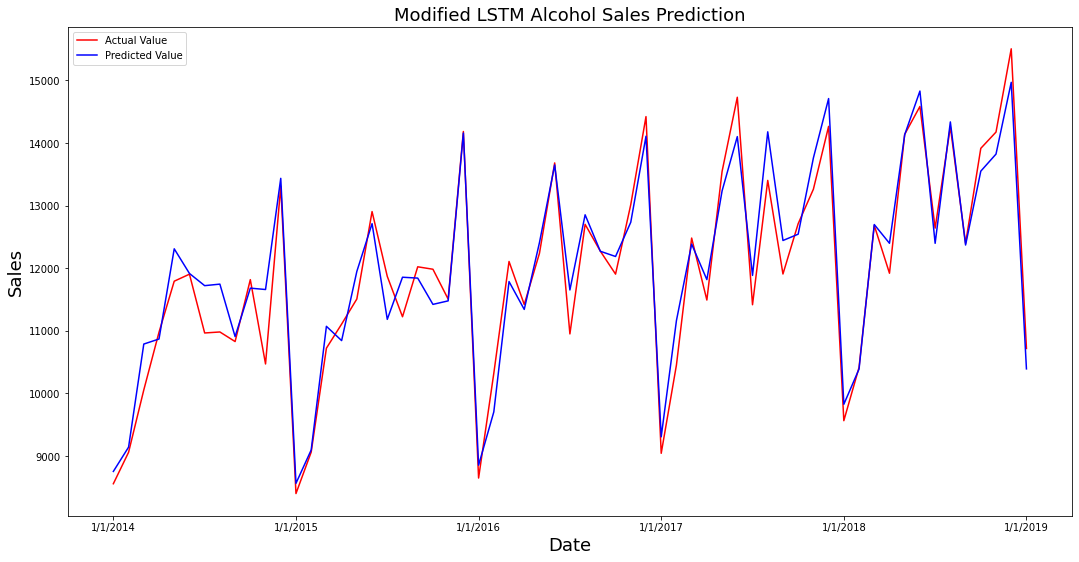

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(df.iloc[num_train:, 0], df.iloc[num_train:, 1:2].values, color = "red", label = "Actual Value")
plt.plot(df.iloc[num_train:, 0], LSTM_predict_new, color = "blue", label = "Predicted Value")
plt.xticks(np.arange(0,num_test,12))
plt.title('Modified LSTM Alcohol Sales Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.legend()
plt.show()

The modified LSTM model fits the test dataset significantly better than the previous model, and the performance doesn't deteriorate as the sales values increase.